In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.patches import Ellipse
import seaborn as sns
from pathlib import Path

In [21]:
from multibind.nonequilibrium import rate_matrix
import multibind as mb

In [22]:
import numpy as np

# Solve for the rates

In [23]:
input_rates = Path('inputs/rates.csv')
assert input_rates.exists()

c, k, std = rate_matrix(input_rates)

states = c.states.values
free_energies = c.g_mle

grouped = np.vstack([states.flatten(), free_energies])

In [24]:
for i, j in zip(states.flatten(), free_energies):
    print(i, j)

ifh 0.0
if0 -3.550057819332115
ifn -4.880139363544365
ofn -4.377414269911992
of0 -3.727560919797326
ofh -0.5025464485910369


In [25]:
for i in range(len(states)):
    state_i = states[i][0]
    if i == 0:
        print(' '*10, end='')
        for l in states.flatten():
            print(f"{l:>10}", end='') 
        print('')
    for j in range(len(states)):
        state_j = states[j][0]
        if j == 0:
            print(f'{state_i:>10}', end='')
        dg = free_energies[j] - free_energies[i]
        print(f"{dg:10.2f}", end='')
    print()

                 ifh       if0       ifn       ofn       of0       ofh
       ifh      0.00     -3.55     -4.88     -4.38     -3.73     -0.50
       if0      3.55      0.00     -1.33     -0.83     -0.18      3.05
       ifn      4.88      1.33      0.00      0.50      1.15      4.38
       ofn      4.38      0.83     -0.50      0.00      0.65      3.87
       of0      3.73      0.18     -1.15     -0.65      0.00      3.23
       ofh      0.50     -3.05     -4.38     -3.87     -3.23      0.00


In [26]:
for i in range(len(states)):
    state_i = states[i][0]
    if i == 0:
        print(' '*10, end='')
        for l in states.flatten():
            print(f"{l:>10}", end='') 
        print('')
    for j in range(len(states)):
        state_j = states[j][0]
        if j == 0:
            print(f'{state_i:>10}', end='')
        rate = k[i, j]
        print(f"{rate:10.4f}", end='')
    print()

                 ifh       if0       ifn       ofn       of0       ofh
       ifh    0.0000 6961.3862    0.0000    0.0000    0.0000 9905.5281
       if0  199.9517    0.0000 2070.9013    0.0000    0.0000    0.0000
       ifn    0.0000  547.6616    0.0000 5792.4753    0.0000    0.0000
       ofn    0.0000    0.0000 9576.2379    0.0000  114.6841    0.0000
       of0    0.0000    0.0000    0.0000  219.6498    0.0000  292.8158
       ofh 5992.7269    0.0000    0.0000    0.0000 7365.4712    0.0000


In [28]:
for i in range(len(states)):
    state_i = states[i][0]
    if i == 0:
        print(' '*10, end='')
        for l in states.flatten():
            print(f"{l:>10}", end='') 
        print('')
    for j in range(len(states)):
        state_j = states[j][0]
        if j == 0:
            print(f'{state_i:>10}', end='')
        rate = std[i, j]
        print(f"{rate:10.2f}", end='')
    print()

                 ifh       if0       ifn       ofn       of0       ofh
       ifh      0.00   9410.57      0.00      0.00      0.00   7322.65
       if0    270.07      0.00   2288.94      0.00      0.00      0.00
       ifn      0.00    604.30      0.00   4293.30      0.00      0.00
       ofn      0.00      0.00   7077.41      0.00    105.57      0.00
       of0      0.00      0.00      0.00    201.94      0.00     16.11
       ofh   4435.16      0.00      0.00      0.00    311.34      0.00


## Example solve

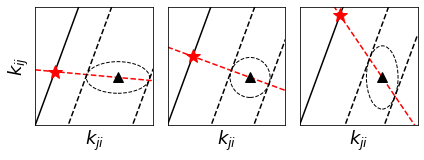

In [9]:
def make_plot(ax, kji, vji, kij, vij, scale, target_dg, ylabel=True):
    dG_original = -np.log(kij / kji)
    new_dG = target_dg

    b_weight = np.exp(-new_dG)
    s_ijji = vij/vji
    s_jiij = vji/vij

    kjip = kji / (1 + s_jiij * b_weight**2) + kij / (s_ijji / b_weight + b_weight)
    kijp = kjip * b_weight

    kjis = np.linspace(0, 100)
    kijs = kjis * np.exp(-dG_original)
    kijsprime = kjis * np.exp(-new_dG)

    perp = kij - s_ijji * (kjis - kji) / b_weight
    shift = np.sqrt(vji**2 * scale**2 / (vji + vij * b_weight**-2))
    tangent_left = (kjis - kji + shift)*b_weight + kij
    tangent_right = (kjis - kji - shift)*b_weight + kij

    y1 = kij - s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))
    y2 = kij + s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))

    x1 = kji + np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))
    x2 = kji - np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))

    b1 = y1 - b_weight * x1
    b2 = y2 - b_weight * x2

    t1 = kjis * b_weight + b1
    t2 = kjis * b_weight + b2

    ellipse_out = Ellipse((kji, kij), 
                          2*np.sqrt(vji*scale**2), 
                          2*np.sqrt(vij*scale**2), 
                          color='black', 
                          fill=False,
                          ls='--')
        
    ax.add_patch(ellipse_out)
    
    #_kjis_perp = kjis[(np.abs(kjis - kjip) < np.abs(kjip - kji)) & \
    #                  (np.abs(kjis - kji) < np.abs(kjip - kji))]
    #perp = kij - s_ijji * (_kjis_perp - kji) / b_weight
    
    ax.plot(kjis, perp, '--', color='red')
    #ax.plot(_kjis_perp, perp, '--', color='red')
    ax.plot(kjis, t1, '--', color='black')
    ax.plot(kjis, t2, '--', color='black')
    ax.plot(kjis, kijsprime, color='black')
    ax.plot([kjip], [kijp], '*', color='red', markersize=15)

    ax.plot([kji], [kij], '^', markersize=10, color='black')

    ax.set_xlabel('$k_{ji}$', fontsize=18)
    ax.set_ylabel('$k_{ij}$' if ylabel else '', fontsize=18)

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    ax.set_aspect('equal')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

param1 = (70, 20, 40, 5, 6, -1)
param2 = (70, 8, 40, 8, 6, -1)
param3 = (70, 5, 40, 20, 6, -1)

make_plot(ax1, *param1)
make_plot(ax2, *param2, ylabel=False)
make_plot(ax3, *param3, ylabel=False)

plt.tight_layout()
plt.savefig('img/panel.pdf')

41.010072554861736 15.08676257388284
49.52456961311908 18.21907099353044
57.91378269735129 21.30529001482594
92.78039784394191 34.132000910493446


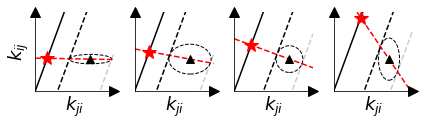

In [10]:
def make_plot(ax, kji, vji, kij, vij, scale, target_dg, ylabel=True):
    dG_original = -np.log(kij / kji)
    new_dG = target_dg

    b_weight = np.exp(-new_dG)
    s_ijji = vij/vji
    s_jiij = vji/vij

    kjip = kji / (1 + s_jiij * b_weight**2) + kij / (s_ijji / b_weight + b_weight)
    kijp = kjip * b_weight

    kjis = np.linspace(0, 100)
    kijs = kjis * np.exp(-dG_original)
    kijsprime = kjis * np.exp(-new_dG)
    print(kijp, kjip)

    perp = kij - s_ijji * (kjis - kji) / b_weight
    shift = np.sqrt(vji**2 * scale**2 / (vji + vij * b_weight**-2))
    tangent_left = (kjis - kji + shift)*b_weight + kij
    tangent_right = (kjis - kji - shift)*b_weight + kij

    y1 = kij - s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))
    y2 = kij + s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))
    
    x1 = kji + np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))
    x2 = kji - np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))

    b1 = y1 - b_weight * x1
    b2 = y2 - b_weight * x2

    t1 = kjis * b_weight + b1
    t2 = kjis * b_weight + b2

    ellipse_out = Ellipse((kji, kij), 
                          2*np.sqrt(vji*scale**2), 
                          2*np.sqrt(vij*scale**2), 
                          color='black', 
                          fill=False,
                          ls='--')
        
    ax.add_patch(ellipse_out)
    
    #_kjis_perp = kjis[(np.abs(kjis - kjip) < np.abs(kjip - kji)) & \
    #                  (np.abs(kjis - kji) < np.abs(kjip - kji))]
    #perp = kij - s_ijji * (_kjis_perp - kji) / b_weight
    
    ax.plot(kjis, perp, '--', color='red')
    
    t1_proj = t1[np.argmin((kjis - kji)**2)]
    t2_proj = t2[np.argmin((kjis - kji)**2)]
    
    bounds = [kjip, kji]
    bounds.sort()
    
    x1_in_between = x1 > bounds[0] and x1 < bounds[1] 
    x2_in_between = x2 > bounds[0] and x2 < bounds[1]
    
    alpha = 0.2
    
    ax.plot(kjis, t1, '--', color='black', alpha=(1 if x1_in_between else alpha))
    ax.plot(kjis, t2, '--', color='black', alpha=(1 if x2_in_between else alpha))
    ax.plot(kjis, kijsprime, color='black')
    ax.plot([kjip], [kijp], '*', color='red', markersize=15)

    ax.plot([kji], [kij], '^', markersize=8, color='black')

    ax.set_xlabel('$k_{ji}$', fontsize=18)
    ax.set_ylabel('$k_{ij}$' if ylabel else '', fontsize=18)

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    ax.set_aspect('equal')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.plot((100), (0), ls="", marker=">", ms=10, color="k",
            clip_on=False)
    ax.plot((0), (100), ls="", marker="^", ms=10, color="k",
            clip_on=False)
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

param0 = (70, 20, 40, 1, 6, -1)
param1 = (70, 20, 40, 10, 6, -1)
param2 = (70, 8, 40, 8, 6, -1)
param3 = (70, 5, 40, 20, 6, -1)

make_plot(ax1, *param0)
make_plot(ax2, *param1, ylabel=False)
make_plot(ax3, *param2, ylabel=False)
make_plot(ax4, *param3, ylabel=False)


plt.tight_layout()
plt.savefig('img/panel_extreme.pdf')

41.010072554861736 15.08676257388284
49.52456961311908 18.21907099353044
57.91378269735129 21.30529001482594
92.78039784394191 34.132000910493446


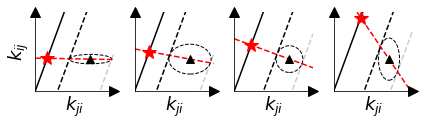

In [11]:
def make_plot(ax, kji, vji, kij, vij, scale, target_dg, ylabel=True):
    dG_original = -np.log(kij / kji)
    new_dG = target_dg

    b_weight = np.exp(-new_dG)
    s_ijji = vij/vji
    s_jiij = vji/vij

    kjip = kji / (1 + s_jiij * b_weight**2) + kij / (s_ijji / b_weight + b_weight)
    kijp = kjip * b_weight

    kjis = np.linspace(0, 100)
    kijs = kjis * np.exp(-dG_original)
    kijsprime = kjis * np.exp(-new_dG)
    print(kijp, kjip)

    perp = kij - s_ijji * (kjis - kji) / b_weight
    shift = np.sqrt(vji**2 * scale**2 / (vji + vij * b_weight**-2))
    tangent_left = (kjis - kji + shift)*b_weight + kij
    tangent_right = (kjis - kji - shift)*b_weight + kij

    y1 = kij - s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))
    y2 = kij + s_ijji / b_weight * np.sqrt((vji**2 * scale**2) / \
                                           (vji + vij / b_weight**2))
    
    x1 = kji + np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))
    x2 = kji - np.sqrt((vji**2 * scale**2)/ \
                       (vji + vij / b_weight**2))

    b1 = y1 - b_weight * x1
    b2 = y2 - b_weight * x2

    t1 = kjis * b_weight + b1
    t2 = kjis * b_weight + b2

    ellipse_out = Ellipse((kji, kij), 
                          2*np.sqrt(vji*scale**2), 
                          2*np.sqrt(vij*scale**2), 
                          color='black', 
                          fill=False,
                          ls='--')
        
    ax.add_patch(ellipse_out)
    
    #_kjis_perp = kjis[(np.abs(kjis - kjip) < np.abs(kjip - kji)) & \
    #                  (np.abs(kjis - kji) < np.abs(kjip - kji))]
    #perp = kij - s_ijji * (_kjis_perp - kji) / b_weight
    
    ax.plot(kjis, perp, '--', color='red')
    
    t1_proj = t1[np.argmin((kjis - kji)**2)]
    t2_proj = t2[np.argmin((kjis - kji)**2)]
    
    bounds = [kjip, kji]
    bounds.sort()
    
    x1_in_between = x1 > bounds[0] and x1 < bounds[1] 
    x2_in_between = x2 > bounds[0] and x2 < bounds[1]
    
    alpha = 0.2
    
    ax.plot(kjis, t1, '--', color='black', alpha=(1 if x1_in_between else alpha))
    ax.plot(kjis, t2, '--', color='black', alpha=(1 if x2_in_between else alpha))
    ax.plot(kjis, kijsprime, color='black')
    ax.plot([kjip], [kijp], '*', color='red', markersize=15)

    ax.plot([kji], [kij], '^', markersize=8, color='black')

    ax.set_xlabel('$k_{ji}$', fontsize=18)
    ax.set_ylabel('$k_{ij}$' if ylabel else '', fontsize=18)

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    ax.set_aspect('equal')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.plot((100), (0), ls="", marker=">", ms=10, color="k",
            clip_on=False)
    ax.plot((0), (100), ls="", marker="^", ms=10, color="k",
            clip_on=False)
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

param0 = (70, 20, 40, 1, 6, -1)
param1 = (70, 20, 40, 10, 6, -1)
param2 = (70, 8, 40, 8, 6, -1)
param3 = (70, 5, 40, 20, 6, -1)

make_plot(ax1, *param0)
make_plot(ax2, *param1, ylabel=False)
make_plot(ax3, *param2, ylabel=False)
make_plot(ax4, *param3, ylabel=False)


plt.tight_layout()
plt.savefig('img/panel_extreme.pdf')